In [1]:
import numpy as np
from scipy.sparse import eye, csr_matrix
from scipy.linalg import inv, khatri_rao

def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def bohman(loghyper, x):
    range_ = np.exp(loghyper[0])
    dis = np.abs(x[:, None] - x[None, :])
    r = np.minimum(dis / range_, 1)
    k = (1 - r) * np.cos(np.pi * r) + np.sin(np.pi * r) / np.pi
    k[np.isnan(k)] = 0
    return k

def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def fold(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

def kronecker_matrix_vector(vector, K1, K2, K3):
    M, N = vector.shape
    temp1 = ((K3 @ vector).T).reshape(K2.shape[0], int(M * N / K2.shape[0]), order = "F")
    temp2 = (K2 @ temp1).T.reshape(K1.shape[0], int(M * N / K1.shape[0]), order = "F")
    temp3 = (K1 @ temp2).T
    Qy = temp3.ravel(order = "F")
    return Qy

def cg2_factor(Qu, rho, KrU, mask_matrix, YR_tilde, priorvalue, max_iter):
    x = priorvalue
    M, N = YR_tilde.shape
    Ax1 = x.reshape(M, N, order = "F") @ KrU.T
    Ax1 = Ax1.ravel(order = "F")
    Ax1 = mask_matrix.ravel(order = "F") * Ax1
    Ax1 = Ax1.reshape(M, -1, order = "F") @ KrU
    Ax1 = Ax1.ravel(order = "F")
    Ax2 = rho * Qu @ x.reshape(M, N, order = "F")
    Ax2 = Ax2.ravel(order = "F")
    Ax = Ax1 + Ax2
    r = YR_tilde.ravel(order = "F") - Ax
    p = r
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)  
    for i in range(max_iter):
        Ap1 = p.reshape(M, N, order = "F") @ KrU.T
        Ap1 = Ap1.ravel(order = "F")
        Ap1 = mask_matrix.ravel(order = "F") * Ap1       
        Ap1 = Ap1.reshape(M, -1, order = "F") @ KrU
        Ap1 = Ap1.ravel(order = "F")
        Ap2 = rho * Qu @ p.reshape(M, N, order = "F")
        Ap2 = Ap2.ravel(order = "F")
        Ap = Ap1 + Ap2
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        approxE[i] = np.sqrt(np.dot(r, r))
        if approxE[i] < 1e-6:
            break    
        rsnew = np.dot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew       
    return x, approxE

def cg2_local(gamma, Kd, Kt, Ks, mask_matrix, YR_tilde, priorvalue, max_iter):
    x = priorvalue
    M, N  = YR_tilde.shape   
    Ax1 = kronecker_matrix_vector(x.reshape(M, N, order = "F"), Kd, Kt, Ks)
    Ax2 = mask_matrix.ravel(order = "F") * x
    Ax = Ax1 + gamma * Ax2
    Ax = mask_matrix.ravel(order = "F") * Ax
    r = YR_tilde.ravel(order = "F") - Ax
    p = r
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)
    for i in range(max_iter):
        Ap1 = kronecker_matrix_vector(p.reshape(M, N, order = "F"), Kd, Kt, Ks)
        Ap2 = mask_matrix.ravel(order = "F") * p
        Ap = Ap1 + gamma * Ap2
        Ap = mask_matrix.ravel(order = "F") * Ap
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        approxE[i] = np.sqrt(np.dot(r, r))
        if approxE[i] < 1e-6:
            break       
        rsnew = np.dot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    return x, approxE

def GLSKF(I, Omega, lengthscaleU: list, lengthscaleR: list, varianceU: list, varianceR: list, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon):
    N = np.array(I.shape)
    D = I.ndim
    maxP = float(np.max(I))
    
    pos_miss = np.where(Omega == 0)
    num_obser = np.sum(Omega)
    mask_matrix = [unfold(Omega, d) for d in range(D)]
    idx = np.sum(mask_matrix[2], axis = 0) > 0
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    T = Isubmean * Omega

    hyper_Ku = [None] * D
    hyper_Ku[0] = [np.log(lengthscaleU[0]), np.log(varianceU[0])]
    hyper_Ku[1] = [np.log(lengthscaleU[1]), np.log(varianceU[1])]   
    hyper_Kr = [None] * D
    hyper_Kr[0] = [np.log(lengthscaleR[0]), np.log(varianceR[0]), np.log(tapering_range)]
    hyper_Kr[1] = [np.log(lengthscaleR[1]), np.log(varianceR[1]), np.log(tapering_range)]

    Ku, Kr = [None] * D, [None] * D
    invKu = [None] * D

    x = np.arange(1, N[0] + 1)
    Ku[0] = cov_matern(d_MaternU, hyper_Ku[0], x)
    invKu[0] = inv(Ku[0])
    TaperM = bohman([hyper_Kr[0][2]], x)
    Kr[0] = cov_matern(d_MaternR, hyper_Kr[0][:2], x) * TaperM

    x = np.arange(1, N[1] + 1)
    Ku[1] = cov_matern(d_MaternU, hyper_Ku[1], x)
    invKu[1] = inv(Ku[1])
    TaperM = bohman([hyper_Kr[1][2]], x)
    Kr[1] = cov_matern(d_MaternR, hyper_Kr[1][:2], x) * TaperM

    invKu[2] = csr_matrix(eye(N[2]))
    Kr[2] = csr_matrix(eye(N[2]))

    X = T
    X[pos_miss] = T.sum() / num_obser
    U = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    M_unfold1 = U[0] @ khatri_rao(U[2], U[1]).T
    M = fold(M_unfold1, N, 0)
    Uvector = [U[d].ravel(order = "F") for d in range(D)]
    Rtensor = np.zeros(N)
    Rvector = Rtensor.ravel(order = "F")   
    Rvector_temp = Rtensor.ravel(order = "F")
    X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]

    d_all = np.arange(0, D)
    train_norm = np.linalg.norm(T)
    last_ten = T.copy()
    psnrf = np.zeros(maxiter)
    approxU = [None] * D
    iter = 0
    while True:
        Gtensor = X - Rtensor
        Gtensor_mask = Gtensor * Omega
        for d in range(D):
            dsub = np.delete(d_all, d)
            KrU = khatri_rao(U[dsub[1]], U[dsub[0]])
            HG = unfold(Gtensor_mask, d) @ KrU
            Uvector[d], approxU[d] = cg2_factor(invKu[d], rho, KrU, mask_matrix[d], HG, Uvector[d], 1000)
            U[d] = Uvector[d].reshape(N[d], R, order = "F")
        M_unfold1 = U[0] @ (khatri_rao(U[2], U[1]).T)
        M = fold(M_unfold1, N, 0)
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        if iter > K0:
            Ltensor = X - M
            Ltensor_mask = Ltensor * Omega
            Rvector_temp, approxE = cg2_local(
                gamma, Kr[2], Kr[1], Kr[0], mask_matrix[0], Ltensor_mask.reshape(N[0], -1, order = "F"), Rvector_temp, 1000
            )
            Rvector = kronecker_matrix_vector(Rvector_temp.reshape(N[0], N[1]*N[2], order = "F"), Kr[2], Kr[1], Kr[0])
            Rtensor = Rvector.reshape(N, order = "F")
            Rtensor_unfold3 = unfold(Rtensor, 2)
            Rtensor_unfold3_obs = Rtensor_unfold3[:, idx]
            Kr[2] = np.cov(Rtensor_unfold3_obs)          
        else:
            Rtensor = np.zeros_like(Rtensor)    
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        Xori = X + np.mean(train_matrix)
        Xrecovery = np.maximum(0, Xori)
        Xrecovery = np.minimum(maxP, Xrecovery)
        mseC1 = np.linalg.norm(I[:, :, 0].astype(float) - Xrecovery[:, :, 0], 'fro') ** 2 / (N[0] * N[1])
        psnrC1 = 10 * np.log10(maxP**2 / mseC1)
        mseC2 = np.linalg.norm(I[:, :, 1].astype(float) - Xrecovery[:, :, 1], 'fro') ** 2 / (N[0] * N[1])
        psnrC2 = 10 * np.log10(maxP**2 / mseC2)
        mseC3 = np.linalg.norm(I[:, :, 2].astype(float) - Xrecovery[:, :, 2], 'fro') ** 2 / (N[0] * N[1])
        psnrC3 = 10 * np.log10(maxP**2 / mseC3)
        psnrf[iter] = (psnrC1 + psnrC2 + psnrC3)/3
        iter += 1
        print(f"Epoch = {iter}, PSNR = {psnrf[iter-1]}")
        tol = np.linalg.norm((X - last_ten)) / train_norm
        last_ten = X.copy()       
        if (tol < epsilon) or (iter >= maxiter):
            break
    return Xori, Rtensor + np.mean(train_matrix), M + np.mean(train_matrix)

In [2]:
from PIL import Image
import scipy.io
seedr = 6
np.random.seed(seedr)
I = np.array(Image.open('./data/original/airplane.tiff'))
Omega = scipy.io.loadmat('./data/mask/airplane_90RM.mat')['Omega']
lengthscaleU = np.ones(2) * 30
varianceU = np.ones(2)
lengthscaleR = np.ones(2) * 5
varianceR = np.ones(2)
tapering_range = 30
d_MaternU, d_MaternR = 3, 3
R = 10
rho, gamma = 20, 5
maxiter, K0 = 30, 10
epsilon = 1e-4
X, Rtensor, Mtensor = GLSKF(I, Omega, lengthscaleU, lengthscaleR, varianceU, varianceR, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon)

Epoch = 1, PSNR = 17.58373539454962
Epoch = 2, PSNR = 19.797694271812542
Epoch = 3, PSNR = 20.333483976596643
Epoch = 4, PSNR = 20.557693153380754
Epoch = 5, PSNR = 20.6848763112169
Epoch = 6, PSNR = 20.76230116896955
Epoch = 7, PSNR = 20.810999434220594
Epoch = 8, PSNR = 20.84481170002798
Epoch = 9, PSNR = 20.869604587744362
Epoch = 10, PSNR = 20.889658357393206
Epoch = 11, PSNR = 20.908591957610863
Epoch = 12, PSNR = 23.24042536799041
Epoch = 13, PSNR = 27.00631850159313
Epoch = 14, PSNR = 27.327202008570655
Epoch = 15, PSNR = 27.33987815910667
Epoch = 16, PSNR = 27.343405361875977
Epoch = 17, PSNR = 27.346131783162217
Epoch = 18, PSNR = 27.34811971907995
Epoch = 19, PSNR = 27.35015242505004
Epoch = 20, PSNR = 27.351668373187056
Epoch = 21, PSNR = 27.353194192717638
Epoch = 22, PSNR = 27.354510611020952
Epoch = 23, PSNR = 27.35569435821154
Epoch = 24, PSNR = 27.356745045800604
Epoch = 25, PSNR = 27.357667204031987
Epoch = 26, PSNR = 27.358418869687203
Epoch = 27, PSNR = 27.3591338511

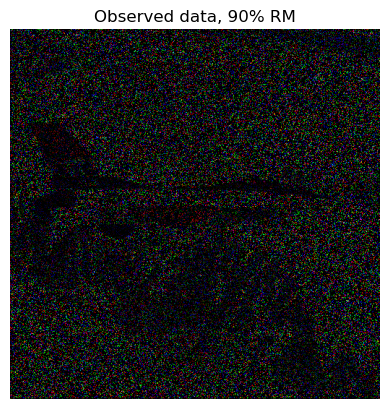

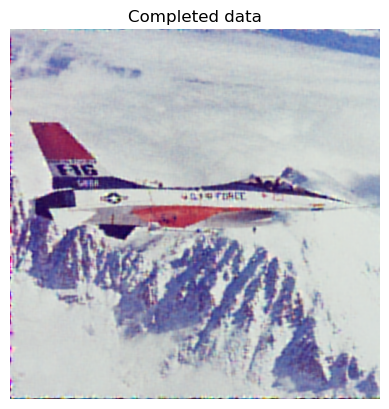

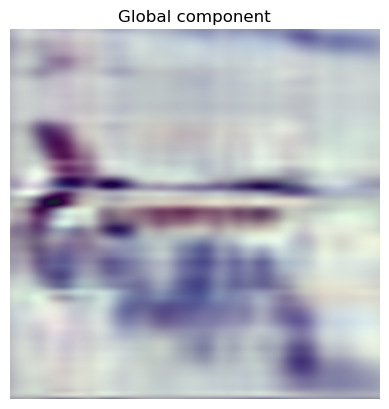

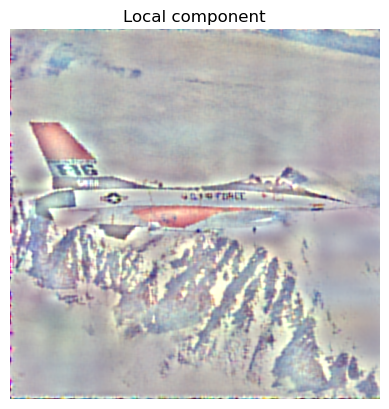

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(I * Omega))))
plt.title('Observed data, 90% RM')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(X))))
plt.title('Completed data')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(Mtensor))))
plt.title('Global component')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(Rtensor))))
plt.title('Local component')
plt.axis("off")
plt.show()